In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import kornia
import cv2
import tqdm
import numpy as np
import einops
import timm
import numpy as np
from PIL import Image
import random



with open("imagenet1000_clsidx_to_labels.txt", 'r') as labels_file:
    labels = labels_file.read().splitlines()


    
def standardize(tensor):
    with torch.no_grad():
        tensor = tensor - tensor.min()
        tensor = tensor / tensor.max()
    
    return tensor


In [2]:
augment = True
jitter = True
blur = True
flip = False



batch_transforms = torch.nn.Sequential(
    
    kornia.augmentation.RandomAffine(
        degrees=30,
#         translate=[0.05, 0.05],
#         scale=[0.9, 1.1], 
        same_on_batch=False,
        padding_mode=1,
        p=1 * augment,
    ),
    
    kornia.augmentation.RandomResizedCrop(
        size=(224, 224), 
        scale=(0.5, 1.0),
        ratio=(0.5, 2.0), #aspect ratio

    ),


    
    kornia.augmentation.ColorJitter(
        brightness=0.05, 
        contrast= 0.05, 
        saturation= 0.05, 
        hue= 0.05, 
        same_on_batch=False,
        p=1. * jitter,
    ),

    kornia.augmentation.GaussianBlur(
        kernel_size=(5, 5),
        sigma=(1., 1.),
        same_on_batch=False,
        p=0.5 * blur,
    ),

    
    kornia.augmentation.RandomHorizontalFlip(
        p = 0.5 * flip,
    ),
    
#     kornia.augmentation.RandomVerticalFlip(),

    
    
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    
                                          
)


      
# sample_img = torchvision.transforms.functional.to_tensor(Image.open('./0266554465.jpeg').resize([224, 224]))


# sample_img_batch = einops.repeat(sample_img, 'c h w -> (repeat) c h w', repeat = 16)
# transformed_sample_img_batch = batch_transforms(sample_img_batch)
# for im in transformed_sample_img_batch:
#     plt.imshow(kornia.tensor_to_image(im)); plt.show()
    

In [3]:


models = [
    'vit_base_patch16_224', 
#     'resnet50', 
    'tf_efficientnet_b0_ap', 
     'adv_inception_v3', 
     'inception_v4',
#     'dla102',
    'densenet121',
#     'mobilenetv3_large_100',
     'resnext101_32x8d',
#     'seresnet152d'
#     'resnet18',
    'ig_resnext101_32x16d',
     'nf_resnet50',

]

network_dicts = [ {'name': name, 'net': timm.create_model(name, pretrained=True)} for name in models]



for net_dict in network_dicts:
    net = net_dict['net'].cuda().eval()
    for param in net.parameters():
        param.requires_grad = False
  



In [4]:

input_tensor = torch.distributions.Normal(0.0, 0.1).sample([1, 3, 512, 512]).cuda()
input_tensor.requires_grad=True




# input_img = torchvision.transforms.functional.to_tensor(
#     Image.open('./cat.4002.jpg').resize([224, 224])
# ).unsqueeze(0).cuda()


# input_tensor = torch.logit(input_img, eps=1e-4)
# input_tensor.requires_grad = True









max_list = []
grads_max_list = []
img_grads_max_list = []
activations = []
images = []
grad_images = []

TARGET_CLASSES = [388]

for target_class in TARGET_CLASSES:
    print(labels[target_class])

optimizer = torch.optim.Adam([input_tensor], lr=0.05, weight_decay=1e-5)

 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',


100%|██████████| 5000/5000 [05:07<00:00, 16.25it/s]


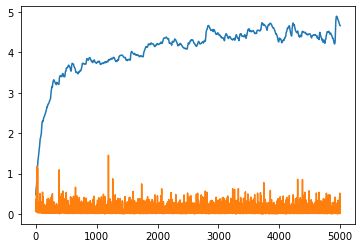

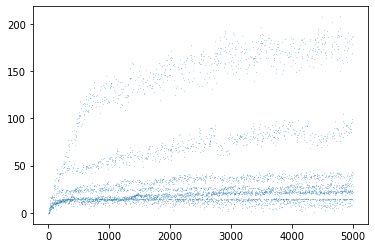

In [5]:


ITERATIONS = 5000
BATCH_SIZE = 4
TV_LOSS_COEFF = 500


for n in tqdm.tqdm(range(ITERATIONS)):

   
    input_img = torch.sigmoid(input_tensor)    
    input_img.retain_grad()

    net_dict = random.choice(network_dicts)
    
    net = net_dict['net']
    input_img_batch = einops.repeat(input_img, 'b c h w -> (b repeat) c h w', repeat = BATCH_SIZE)
    transformed_input_img_batch = batch_transforms(input_img_batch)

    
    out = net(transformed_input_img_batch)
    target = out[:, TARGET_CLASSES].mean()
    activations.append(target.item())


    tv_loss = kornia.losses.total_variation(input_img[0]) / torch.numel(input_img[0])
    
    
    loss = tv_loss * TV_LOSS_COEFF - target
  
    loss.backward()
    
    

        
    
    max_list.append(abs(input_tensor.max().item()))
    
    grads_max_list.append(abs(input_tensor.grad.max().item()))
    
    if n % 10 == 0:
        images.append(
            np.uint8(
                kornia.tensor_to_image(input_img[0]) * 255
            )
        )
    
 
    
    
    optimizer.step()
    optimizer.zero_grad()
    

    
plt.figure(); 
plt.plot(max_list); 
plt.plot(grads_max_list); 
plt.show()



plt.figure()
plt.scatter(np.arange(len(activations)), activations, s=0.01)
plt.show()




8it [00:00,  9.01it/s]


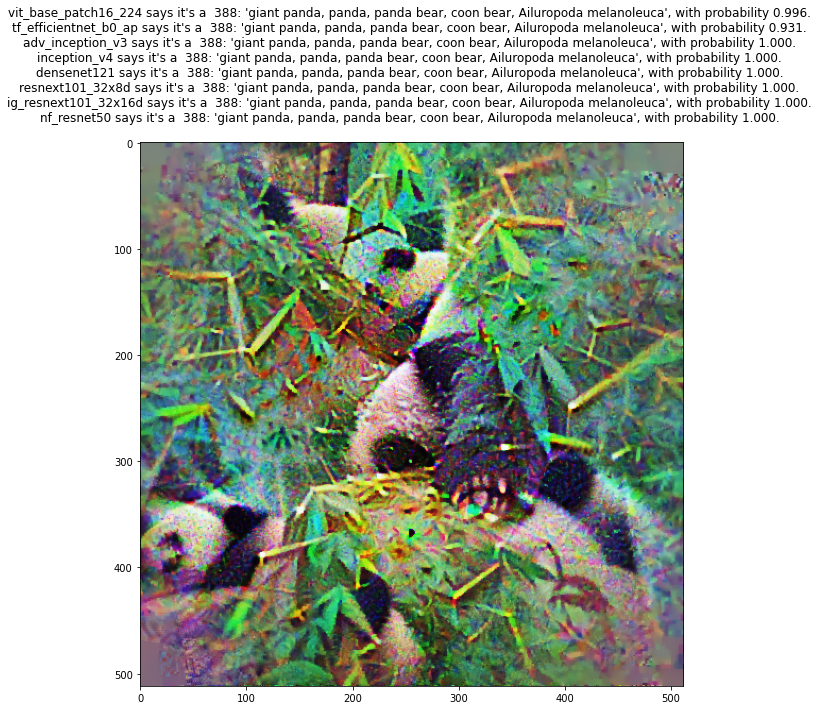

In [10]:
plt.figure(figsize=[10, 10])

plt.imshow(kornia.tensor_to_image(input_img[0]))


title_string = ''
with torch.no_grad():
    for n, net_dict in tqdm.tqdm(enumerate(network_dicts)):
        net = net_dict['net']
        input_img_batch = einops.repeat(input_img, 'b c h w -> (b repeat) c h w', repeat = 32)
        transformed_input_img_batch = batch_transforms(input_img_batch)

        out = net(transformed_input_img_batch).mean(dim=0)
        
        out_argmax = torch.argmax(out, -1).item()
        out_probs = torch.softmax(out, -1)
        out_label = labels[out_argmax]
        out_prob  = out_probs[out_argmax].item()
        title_string += f"{net_dict['name']} says it's a {out_label} with probability {out_prob:0.3f}. \n" 
        

plt.title(title_string)
plt.show()





In [7]:
SHAPE = input_tensor.shape[-2:]

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_images = cv2.VideoWriter('images.avi', fourcc, 30., SHAPE)

for frame in images:
    frame = cv2.resize(frame, SHAPE)
    if frame.max() > 1:
        frame = frame * 255.0
    
    frame_int = np.uint8(frame)
    out_images.write(frame_int)

out_images.release()

cv2.imwrite('out_img.png', kornia.tensor_to_image(input_img[0]) * 255)


True

In [8]:
input_tensor.shape[-2:]

torch.Size([512, 512])

In [9]:
# import imageio
# with imageio.get_writer('movie.gif', mode='I') as writer:
#     for frame in tqdm.tqdm(images):
#         writer.append_data(frame)